# Analysis
Notebook that concentrates all the analysis done on the ExTRI2 resource and its validation

In [30]:
__import__('sys').path.append('../scripts/common/'); __import__('notebook_utils').table_of_contents('analysis.ipynb')

<h3>Table of contents</h3>


[Analysis](#Analysis)
- [Setup & configuration](#Setup-&-configuration)
- [2.2. Pipeline Results](#2.2.-Pipeline-Results)
- [3.3. Classifiers dataset improvement](#3.3.-Classifiers-dataset-improvement)
- [The ExTRI2 resource - OLD](#The-ExTRI2-resource---OLD)

## Setup & configuration

In [1]:
# IMPORTS
import pandas as pd
import numpy as np
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import upsetplot
import warnings
from analysis import *


from Bio import Entrez
# *Always* tell NCBI who you are
Entrez.email = "example24@gmail.com"

## Custom functions
import sys

sys.path.append('../scripts/common/')
from notebook_utils import table_of_contents, table_from_dict, h3, h4, h5, md
from analysis import load_config, retrieve_annotations_entrez
pd.set_option('display.max_colwidth', 20)

In [2]:
# UNCOMMENT TO REIMPORT A CERTAIN FUNCTION AFTER MODIFYING ITS CODE
import importlib 
import analysis
importlib.reload(analysis)
from analysis import *

In [144]:
# LOAD & PREPROCESSING
config = load_config()

# Load ExTRI dataset
ExTRI2_df = pd.read_csv(config['final_ExTRI2_p'], sep="\t", dtype=str, keep_default_na=False)

# LOAD VALIDATION DATASET
# Load the two validation datasets
validated_df           = pd.read_csv(config['final_validated_p'], sep='\t', header=0, dtype=str)
validated_prerenorm_df = pd.read_csv(config['prerenorm_validated_p'], sep='\t', header=0, dtype=str)

# Join the two validation dataframes
validated_df['pre-post'] = 'post'
validated_prerenorm_df['pre-post'] = 'pre'
validated_df = pd.concat([validated_df, validated_prerenorm_df], ignore_index=True)

# Fill up the NaNs in the true_label & true_MoR columns
validated_df['true_label'] = validated_df['true_label'].fillna(validated_df['Label'])
validated_df['true_MoR'] = validated_df['true_MoR'].fillna(validated_df['MoR'])

# Drop MoRs where true_label is False
validated_df['true_MoR'] = validated_df.apply(lambda x: x['true_MoR'] if x['true_label'] == 'TRUE' else np.nan, axis=1)
validated_df['MoR'] = validated_df.apply(lambda x: x['MoR'] if x['true_label'] == 'TRUE' else np.nan, axis=1)

## 2.2. Pipeline Results

In [ ]:
def split_in_dbTF_coTF_ll_coTF(ExTRI2_df):
    m_dbTF = ExTRI2_df['TF_type'].str.contains('dbTF')
    m_coTF = ExTRI2_df['TF_type'].apply(lambda x: 'coTF' in set(x.split(';'))) & ~m_dbTF
    m_ll_coTF = ExTRI2_df['TF_type'].str.contains('ll_coTF') & ~m_dbTF & ~m_coTF

    dbTF_df = ExTRI2_df[m_dbTF]
    coTF_df = ExTRI2_df[m_coTF]
    ll_coTF_df = ExTRI2_df[m_ll_coTF]

    return dbTF_df, coTF_df, ll_coTF_df    

dbTF_df, coTF_df, ll_coTF_df = split_in_dbTF_coTF_ll_coTF(ExTRI2_df)

In [ ]:
# TABLES 1, 2
def table_1(ExTRI2_df, dbTF_df, coTF_df, ll_coTF_df) -> dict:

    h3("Table 1")

    analysis_dfs = []
    for df, name in [(ExTRI2_df, 'Total'), (dbTF_df, 'dbTF'), (coTF_df, 'coTF'), (ll_coTF_df, 'll_coTF')]:

        analytics = {}
        analytics['TRI-sentences'] = f"{len(df):,}"

        for mor in ['UNDEFINED', 'ACTIVATION', 'REPRESSION']:
            analytics[mor] = f"{len(df[df['MoR'] == mor]):,} ({len(df[df['MoR'] == mor])/len(df):.2%})"
        
        analytics['TG is not normalized'] = f"{(df['TG Id'].isna()).sum():,} ({(df['TG Id'].isna()).sum() / len(df):.2%})"
        analytics['TF is mutated'] = f"{(df['Mutated_TF'] == 'True').sum():,} ({(df['Mutated_TF'] == 'True').sum() / len(df):.2%})"
        analytics['Unique TRIs'] = f"{df['TRI Id'].nunique():,}"

        for T in ['TF', 'TG']:
            analytics[f'Unique {T} IDs'] = f"{df[f'{T} Id'].nunique():,}"
            analytics[f'Unique human {T} IDs'] = f"{df[df[f'{T} TaxID'] == '9606'][f'{T} Id'].nunique():,}"

        # Convert the analytics dictionary to a DataFrame and add it to the list
        analysis_df = pd.DataFrame.from_dict(analytics, orient='index', columns=[name])
        analysis_dfs.append(analysis_df)

    display(pd.concat(analysis_dfs, axis=1))
    return 

def table_2(final_df, dbTF_df):

    # Obtained from other sources
    all_pmids = 38_776_000
    has_gene_entities = 6_507_211

    # Get the number of PMIDs in candidate sentences
    candidate_sents = pd.read_csv(config['raw_ExTRI2_p'], sep='\t', header=1, chunksize=1_000_000, keep_default_na=False)
    candidate_PMIDs = set()
    for chunk in candidate_sents:
        PMIDs = chunk['#SentenceID'].apply(lambda row: row.split(':')[1])
        candidate_PMIDs.update(PMIDs)

    has_TRIs = final_df['PMID'].nunique()
    has_dbTF_TRIs = dbTF_df['PMID'].nunique()

    h3("Table 2")
    analytics = {}
    analytics['All PMIDs'] = f"{all_pmids:,}"
    analytics['Has gene entities'] = f"{has_gene_entities:,} ({has_gene_entities / all_pmids:.2%})"
    analytics['Has candidate sentences'] = f"{len(candidate_PMIDs):,} ({len(candidate_PMIDs) / all_pmids:.2%})"
    analytics['Has TRIs'] = f"{has_TRIs:,} ({has_TRIs / all_pmids:.2%})"
    analytics['Has dbTF TRIs'] = f"{has_dbTF_TRIs:,} ({has_dbTF_TRIs / all_pmids:.2%})"


    analysis_df = pd.DataFrame.from_dict(analytics, orient='index', columns=['Num sentences'])
    # analysis_df.to_excel('tables_figs/table_1.xlsx')
    display(analysis_df)

    return 

table_1(ExTRI2_df, dbTF_df, coTF_df, ll_coTF_df)
table_2(ExTRI2_df, dbTF_df)

<h3>Table 1</h3>

,Total,dbTF,coTF,ll_coTF
TRI-sentences,"836,024","433,146","185,503","217,375"
UNDEFINED,"244,032 (29.19%)","140,063 (32.34%)","55,453 (29.89%)","48,516 (22.32%)"
ACTIVATION,"416,370 (49.80%)","210,977 (48.71%)","77,724 (41.90%)","127,669 (58.73%)"
REPRESSION,"175,622 (21.01%)","82,106 (18.96%)","52,326 (28.21%)","41,190 (18.95%)"
TG is not normalized,0 (0.00%),0 (0.00%),0 (0.00%),0 (0.00%)
TF is mutated,"2,755 (0.33%)","1,336 (0.31%)",865 (0.47%),554 (0.25%)
Unique TRIs,"284,724","143,651","83,280","57,793"
Unique TF IDs,"7,180","3,453","3,078",649
Unique human TF IDs,"2,758","1,280","1,322",156
Unique TG IDs,"25,805","20,609","14,643","13,199"


ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

<h3>Figure 2</h3>

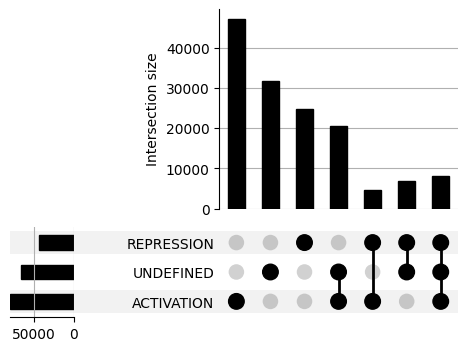

<h3>Table S6</h3>

,Counts
ACTIVATION,"47,148 (32.82%)"
REPRESSION,"24,763 (17.24%)"
UNDEFINED,"31,691 (22.06%)"
"ACTIVATION,REPRESSION","4,613 (3.21%)"
"ACTIVATION,UNDEFINED","20,593 (14.34%)"
"REPRESSION,UNDEFINED","6,735 (4.69%)"
"ACTIVATION,REPRESSION,UNDEFINED","8,108 (5.64%)"
1 MoR,"103,602 (72.12%)"
2 MoR,"31,941 (22.24%)"
3 MoR,"8,108 (5.64%)"


In [ ]:
# FIGURE 2 & TABLE S6
def figure_2(df):
    # 1. Get the sets of TRIs for each MoR

    # Create a set of TRIs for each MoR
    A_set = set(df[df["MoR"] == 'ACTIVATION']['TRI Id'])
    R_set = set(df[df["MoR"] == 'REPRESSION']['TRI Id'])
    U_set = set(df[df["MoR"] == 'UNDEFINED']['TRI Id'])
    # 2. Get the union of these sets
    MoR_listoflists = [
        ['ACTIVATION'], ['REPRESSION'], ['UNDEFINED'],
        ['ACTIVATION', 'REPRESSION'],
        ['ACTIVATION', 'UNDEFINED'],
        ['REPRESSION', 'UNDEFINED'],
        ['ACTIVATION', 'REPRESSION', 'UNDEFINED']
    ]
    MoR_counts = [
        len(A_set - R_set - U_set), 
        len(R_set - A_set - U_set), 
        len(U_set - R_set - A_set),
        len((A_set & R_set) - U_set),
        len((A_set & U_set) - R_set),
        len((U_set & R_set) - A_set),
        len(A_set & R_set & U_set),    
    ]

    # Ignore warnings for upsetplot: it has a lot (library seems like is not updated)
    warnings.filterwarnings('ignore')
    example = upsetplot.from_memberships(MoR_listoflists, data=MoR_counts)
    upsetplot.plot(example)  # doctest: +SKIP
    h3("Figure 2")
    # plt.title("")
    plt.show()
    warnings.filterwarnings('default')

    return MoR_counts, MoR_listoflists

def table_S6(MoR_counts, MoR_listoflists):
    h3("Table S6")
    MoR_counts_table = {}
    for label, count in zip(MoR_listoflists, MoR_counts):
        MoR_counts_table[",".join(label)] = count

    MoR_counts_table['1 MoR'] = sum([MoR_counts_table[MoR] for MoR in ['ACTIVATION', 'REPRESSION', 'UNDEFINED']])
    MoR_counts_table['2 MoR'] = sum([MoR_counts_table[MoR] for MoR in ['ACTIVATION,REPRESSION', 'ACTIVATION,UNDEFINED', 'REPRESSION,UNDEFINED']])
    MoR_counts_table['3 MoR'] = MoR_counts_table['ACTIVATION,REPRESSION,UNDEFINED']
    TOTAL = sum([MoR_counts_table[f'{n} MoR'] for n in range(1, 4)])

    for key, value in MoR_counts_table.items():
        MoR_counts_table[key] = f"{value:,} ({value / TOTAL:.2%})"

    display(pd.DataFrame.from_dict(MoR_counts_table, orient='index', columns=['Counts']))

MoR_counts, MoR_listoflists = figure_2(dbTF_df)
table_S6(MoR_counts, MoR_listoflists)

24402 (0.03) sentences are discarded as their TF/TG is mapped to +1 ID
There are 85 human genes in ExTRI2 that are not found in the all_human_genes df.
They appear in 406 rows, which will be discarded


Number of genes retrieved by category, considering direct human, and mouse/rat orthologs

,human,orthologs,unique,orth.unique,% uniq.,% orth.uniq.
Total,283636,429303,10100,14248,5.3%,10.7%
PROTEIN_CODING,273892,371481,9108,9902,44.2%,48.1%
ncRNA,8108,9975,814,820,3.7%,3.7%
PSEUDO,816,875,107,117,0.6%,0.7%
OTHER,700,610,36,31,4.3%,3.7%
snoRNA,21,25,11,13,0.9%,1.1%
tRNA,43,43,8,8,1.2%,1.2%
snRNA,31,31,7,7,4.2%,4.2%
BIOLOGICAL_REGION,14,0,6,0,0.0%,0.0%
rRNA,1,1,1,1,0.1%,0.1%


<span style='color:red'>There are 3 dbTFs that are non protein-coding. Should we remove them??</span>

,NCBI GeneID,Symbol,Gene Type,Taxonomic Name,Description
8461,100859930,HEIH,ncRNA,Homo sapiens,hepatocellular c...
11907,100288711,DUX4L9,PSEUDO,Homo sapiens,double homeobox ...
17113,58160,NFE4,ncRNA,Homo sapiens,"nuclear factor, ..."


Number of retrieved human dbTFs

,unique,%
all considered,1839,100.0%
human,1271,69.1%
orthologs,1683,91.5%


<h3>Figure 3</h3>

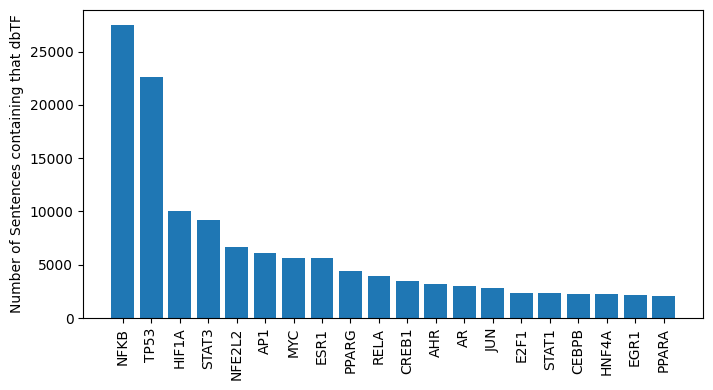

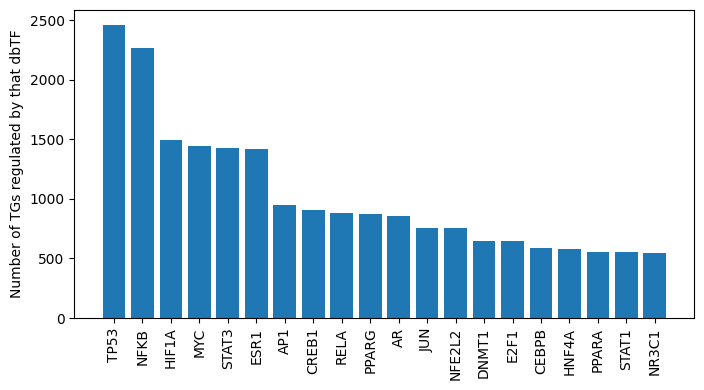

In [ ]:
# 18:38 - 
def load_all_human_genes():
    # Load all human TGs
    # downloaded from: https://www.ncbi.nlm.nih.gov/datasets/gene/taxon/9606/
    all_human_genes = pd.read_csv(config['all_human_TGs_p'], sep='\t', header=0, dtype=str)
    all_human_genes = all_human_genes[['NCBI GeneID', 'Symbol', 'Gene Type', 'Taxonomic Name', 'Description']]
    all_human_genes.loc[all_human_genes['Gene Type'].isna(), 'Gene Type'] = 'nan'

    # Add AP1 and NFKB complexes
    all_human_genes = pd.concat([all_human_genes, pd.DataFrame({
        'NCBI GeneID': ['Complex:AP1', 'Complex:NFKB'], 
        'Symbol': ['AP1', 'NFKB'],
        'Description': ['', ''],
        'Taxonomic Name': ['Homo sapiens', 'Homo sapiens'],
        'Gene Type': ['PROTEIN_CODING', 'PROTEIN_CODING'],
        })], ignore_index=True)
    
    # Ensure the data is expected: all human, no duplicate IDs
    assert all_human_genes['Taxonomic Name'].nunique() == 1
    assert all_human_genes['Taxonomic Name'].unique()[0] == 'Homo sapiens'
    assert (all_human_genes['NCBI GeneID'].duplicated()).sum() == 0 

    return all_human_genes

def display_TG_distribution(human_dbTF_df: pd.DataFrame, dbTF_df: pd.DataFrame, all_human_genes: pd.DataFrame) -> None:
    '''Display how many TGs we have retrieved'''

    # Initialise dict    
    TG_types = {}
    TG_types['Total'] = {
        'human': len(human_dbTF_df),
        'orthologs': len(dbTF_df),
        'unique': len(human_dbTF_df['TG Id'].unique()),
        'orth.unique': len(dbTF_df['TG_human_entrez_gene'].unique()),
        '% uniq.': f"{len(human_dbTF_df['TG Id'].unique()) / len(all_human_genes):.1%}",
        '% orth.uniq.': f"{len(dbTF_df['TG Id'].unique()) / len(all_human_genes):.1%}"
    }

    # Fill in dict
    for gene_type in all_human_genes['Gene Type'].unique():
        human_genes_of_gene_type = all_human_genes[all_human_genes['Gene Type'] == gene_type]['NCBI GeneID']

        human_sents = human_dbTF_df[human_dbTF_df['TG Id'].isin(human_genes_of_gene_type)]
        ortholog_sents = dbTF_df[dbTF_df['TG_human_entrez_gene'].isin(human_genes_of_gene_type)]
        TG_types[gene_type] = {
            'human': len(human_sents),
            'orthologs': len(ortholog_sents),
            'unique': len(human_sents['TG Id'].unique()),
            'orth.unique': len(ortholog_sents['TG_human_entrez_gene'].unique()),
        }
        TG_types[gene_type]['% uniq.']      = f"{TG_types[gene_type]['unique'] / len(human_genes_of_gene_type):.1%}"
        TG_types[gene_type]['% orth.uniq.'] = f"{TG_types[gene_type]['orth.unique'] / len(human_genes_of_gene_type):.1%}"


    # Convert to dataframe & display
    md("Number of genes retrieved by category, considering direct human, and mouse/rat orthologs")
    display(pd.DataFrame.from_dict(TG_types, orient='index').sort_values(by='unique', ascending=False))

def display_TF_distribution(human_dbTF_df, dbTF_df, all_human_genes, ):

    # Check if all dbTFs are protein-coding
    retrieved_TF_IDs = set(human_dbTF_df['TF Id'])
    assert retrieved_TF_IDs - set(all_human_genes['NCBI GeneID']) == set(), "Some dbTFs are not part of the NCBI df"

    # TODO - Fix. Makes no sense non-protein-coding genes can be TFs. 
    #       1. Check where do they come from. TFCheckpoint? (I have to check this anyways)
    #       2. Ask Astrid whether we should remove them
    md("<span style='color:red'>There are 3 dbTFs that are non protein-coding. Should we remove them??</span>")
    non_protein_coding_dbTFs = retrieved_TF_IDs - set(all_human_genes[all_human_genes['Gene Type'] == 'PROTEIN_CODING']['NCBI GeneID'])
    display(all_human_genes[all_human_genes['NCBI GeneID'].isin(non_protein_coding_dbTFs)])

    # Get set of human dbTFs
    with open(config['dbTFs_p'], 'r') as f:
        dbTFs_set = {l.strip('\n') for l in f}
    human_dbTFs_set = dbTFs_set.intersection(set(all_human_genes['NCBI GeneID'])) 

    dbTF_retrieval_t = {
        'all considered': len(human_dbTFs_set),
        'human': len(human_dbTF_df['TF Id'].unique()),
        'orthologs': len(dbTF_df['TF_human_entrez_gene'].unique())
    }
    for k, v in dbTF_retrieval_t.items():
        dbTF_retrieval_t[k] = {
            "unique": v,
            "%": f"{v / len(human_dbTFs_set):.1%}"
        }


    md("Number of retrieved human dbTFs")
    display(pd.DataFrame.from_dict(dbTF_retrieval_t, orient='index'))

def figure_3(human_dbTF_df):
    '''Plot the most common dbTFs'''

    h3("Figure 3")

    # Plot the most common dbTFs
    def plot_counts(df, ylabel):
        counts = df['TF Symbol'].value_counts()
        plt.figure(figsize=(8,4))
        plt.bar(counts[:20].index, counts[:20])
        plt.xticks(rotation='vertical')
        plt.ylabel(ylabel)

    plot_counts(human_dbTF_df, "Number of Sentences containing that dbTF")
    unique_TRIs = human_dbTF_df.drop_duplicates(subset='TRI Id', keep='first')
    plot_counts(unique_TRIs, "Number of TGs regulated by that dbTF")
    plt.show()    


def human_TF_TG_analysis(ExTRI2_df):
    '''Check the category of the found TGs'''

    # Load dataframe of all human genes
    all_human_genes = load_all_human_genes()

    # Show how many sentences have multiple mappings
    multiple_mapped = ((ExTRI2_df['TF Id'].str.contains(';')) | (ExTRI2_df['TG Id'].str.contains(';'))).sum()
    print(f"{multiple_mapped} ({multiple_mapped / len(ExTRI2_df):.2f}) sentences are discarded as their TF/TG is mapped to +1 ID")

    # Filter ExTRI2 by only those containing human dbTFs (ignore those mapped to +1 ids)
    dbTF_df = ExTRI2_df[ExTRI2_df['TF_type'] == 'dbTF']
    human_dbTF_df = dbTF_df[(dbTF_df['TG TaxID'] == '9606') & (dbTF_df['TF TaxID'] == '9606')] 

    # Discard human TGs that are not found in the NCBI human genes df
    # TODO - Ask Astrid if she thinks this is a good approach. Should we remove from the ExTRI2_df too? If so, I should also do mouse & rat
    m_TG_id = human_dbTF_df['TG Id'].isin(all_human_genes['NCBI GeneID'])
    print(f"There are {len(human_dbTF_df[~m_TG_id]['TG Id'].unique())} human genes in ExTRI2 that are not found in the all_human_genes df.")
    print(f"They appear in {(~m_TG_id).sum()} rows, which will be discarded")
    human_dbTF_df = human_dbTF_df[m_TG_id]

    # Show how many TGs we've obtained
    display_TG_distribution(human_dbTF_df, dbTF_df, all_human_genes)

    # Show how many TFs we've obtained
    display_TF_distribution(human_dbTF_df, dbTF_df, all_human_genes)

    # Plot counts
    figure_3(human_dbTF_df)

    return


human_TF_TG_analysis(ExTRI2_df)

## 3.3. Classifiers dataset improvement
See `scripts/classifiers_training/prepare_reannotation_Excels.ipynb` for the figures

## The ExTRI2 resource - OLD

In [ ]:
# TODO - Remove if it is useless for the article

In [ ]:
def get_analytics(df) -> dict:
    h3("General analytics")
    analytics = {}
    analytics['Num sents']      = len(df)
    analytics['Uniq sent-TRI Id'] = set(df['PMID+Sent+TRI_Id'])
    analytics['Uniq sent-TRI']  = set(df['PMID+Sent+TRI'])
    analytics['Uniq PMIDs']     = set(df['PMID'])
    analytics['Uniq TRI Id']    = set(df['TRI Id'])
    
    analytics['Uniq TF Id']     = set(df['TF Id'])
    analytics['Human TF Id']    = set(df[df['TF TaxID'] == '9606']['TF Id'])
    analytics['Human TF Id 2']  = set(df[df['TF TaxID'].str.contains('9606')]['TF Id'])

    analytics['Uniq TG Id']     = set(df['TG Id'])
    analytics['Human TG Id']    = set(df[df['TG TaxID'] == '9606']['TG Id'])
    analytics['Human TG Id 2']  = set(df[df['TG TaxID'].str.contains('9606')]['TG Id'])

    analytics['Num mutated TF']   = (df['Mutated_TF'] == 'True').sum()

    return analytics

def print_analytics(analytics):
    for key, value in analytics.items():
        if type(value) is set:
            num = len(value)
        else:
            num = value
        print(f"{key:<17}{num:,}")

print_analytics(get_analytics(ExTRI2_df))

<h3>General analytics</h3>

Num sents        836,024
Uniq sent-TRI Id 836,024
Uniq sent-TRI    834,723
Uniq PMIDs       293,108
Uniq TRI Id      284,724
Uniq TF Id       7,180
Human TF Id      2,758
Human TF Id 2    3,477
Uniq TG Id       25,805
Human TG Id      12,372
Human TG Id 2    13,591
Num mutated TF   2,755


In [ ]:
def show_analytics(label, num, total):
    total_len = total if type(total) is int else len(total)
    num_len = num if type(num) in (int, np.int64) else len(num)
    print(f'{label:30}{num_len:,}/{total_len:<10,}{num_len/total_len:>10.2%}')

def display_uniques():
    h3("Unique values")
    m_cols = ['#SentenceID', 'Sentence', 'PMID', 'TRI Id', 'PMID+Sent', 'PMID+Sent+TRI', 'PMID+Sent+TRI_Id', '',
            'Valid', 'MoR', 'TF_type', 'TF TaxID', 'TG TaxID', '',
            'TF', 'TF Id', 'TF Symbol', 'TF_human_entrez_gene', 'TF_hgnc_id', 'TF_human_symbol', '',
            'TG', 'TG Id', 'TG Symbol', 'TG_human_entrez_gene', 'TG_hgnc_id', 'TG_human_symbol', 
            'Mutated Genes', 'Mutated_TF']

    total = len(ExTRI2_df)
    for col in m_cols:
        if col == '':
            print()
            continue
        num = ExTRI2_df[col].unique()
        show_analytics(f'Unique {col}', num, total)

def display_NA_values():
    h3("Columns with Na values")
    cols_to_ignore = ['Mutated Genes', 'Mutation offsets', 'tags']

    total = len(ExTRI2_df)
    for col in ExTRI2_df.columns:
        col_has_na = int(ExTRI2_df[col].isna().sum())
        if col_has_na & (col not in cols_to_ignore):
            show_analytics(f'{col}', col_has_na, total)

def display_cols_with_colons():
    h3("Columns with colons (;)")
    colon_cols = ['TF_type', 'TF TaxID', 'TG TaxID', '',
            'TF', 'TF Id', 'TF Symbol', 'TF_human_entrez_gene', 'TF_hgnc_id', 'TF_human_symbol', '',
            'TG', 'TG Id', 'TG Symbol', 'TG_human_entrez_gene', 'TG_hgnc_id', 'TG_human_symbol', 
            'Mutated Genes']

    total = len(ExTRI2_df)
    for col in colon_cols:
        if col == '':
            print()
            continue
        num = int(ExTRI2_df[col].str.contains(';').sum())
        show_analytics(f'{col}', num, total)


    h3("Number of unique rows with ;")
    for col in colon_cols:
        if col == '':
            print()
            continue
        if ExTRI2_df[col].isna().sum() != 0:
            continue
        m = ExTRI2_df[col].str.contains(';')
        num = ExTRI2_df[m][col].unique()
        num_un = ExTRI2_df[col].unique()
        show_analytics(f'{col}', num, num_un)

def display_TF_types():
    h3("Joined TF Types")
    squished = ExTRI2_df['TF_type'].apply(lambda x: ";".join(set(x.split(';'))))
    print(squished.value_counts())
    print()

def display_unique_content_per_col():
    h3("Columns with <30 unique values")
    for col in ExTRI2_df.columns:
        uniq = ExTRI2_df[col].unique()
        if len(uniq) < 30:
            print(f"{col:25}{len(uniq):<10}{', '.join(uniq.astype(str))}")
        # else:
        #     print(f"{col:25}{len(uniq):<10}{', '.join(uniq[:2])}")


# TODO - Understand why there are Na values in hgnc & entrez_gene columns

display_uniques()
display_NA_values()
display_cols_with_colons()
display_TF_types()
display_unique_content_per_col()

<h3>Unique values</h3>

Unique #SentenceID            836,024/836,024      100.00%
Unique Sentence               834,786/836,024       99.85%
Unique PMID                   293,108/836,024       35.06%
Unique TRI Id                 284,724/836,024       34.06%
Unique PMID+Sent              539,924/836,024       64.58%
Unique PMID+Sent+TRI          834,723/836,024       99.84%
Unique PMID+Sent+TRI_Id       836,024/836,024      100.00%

Unique Valid                  1/836,024        0.00%
Unique MoR                    3/836,024        0.00%
Unique TF_type                78/836,024        0.01%
Unique TF TaxID               20/836,024        0.00%
Unique TG TaxID               22/836,024        0.00%

Unique TF                     24,083/836,024        2.88%
Unique TF Id                  7,180/836,024        0.86%
Unique TF Symbol              6,139/836,024        0.73%
Unique TF_human_entrez_gene   4,792/836,024        0.57%
Unique TF_hgnc_id             4,789/836,024        0.57%
Unique TF_human_symbol        4

<h3>Columns with Na values</h3>

<h3>Columns with colons (;)</h3>

TF_type                       16,562/836,024        1.98%
TF TaxID                      16,562/836,024        1.98%
TG TaxID                      8,131/836,024        0.97%

TF                            68/836,024        0.01%
TF Id                         16,562/836,024        1.98%
TF Symbol                     16,562/836,024        1.98%
TF_human_entrez_gene          105,310/836,024       12.60%
TF_hgnc_id                    105,257/836,024       12.59%
TF_human_symbol               105,257/836,024       12.59%

TG                            8/836,024        0.00%
TG Id                         8,131/836,024        0.97%
TG Symbol                     8,131/836,024        0.97%
TG_human_entrez_gene          87,741/836,024       10.50%
TG_hgnc_id                    87,705/836,024       10.49%
TG_human_symbol               87,705/836,024       10.49%
Mutated Genes                 1,760/836,024        0.21%


<h3>Number of unique rows with ;</h3>

TF_type                       75/78            96.15%
TF TaxID                      17/20            85.00%
TG TaxID                      19/22            86.36%

TF                            42/24,083         0.17%
TF Id                         1,200/7,180         16.71%
TF Symbol                     1,141/6,139         18.59%
TF_human_entrez_gene          1,924/4,792         40.15%
TF_hgnc_id                    1,921/4,789         40.11%
TF_human_symbol               1,921/4,789         40.11%

TG                            8/55,571         0.01%
TG Id                         1,965/25,805         7.61%
TG Symbol                     1,902/22,904         8.30%
TG_human_entrez_gene          4,636/17,525        26.45%
TG_hgnc_id                    4,631/17,521        26.43%
TG_human_symbol               4,631/17,522        26.43%
Mutated Genes                 778/2,005         38.80%


<h3>Joined TF Types</h3>

TF_type
dbTF            432325
ll_coTF         216298
coTF            184766
-;ll_coTF         1077
-;coTF             731
coTF;dbTF          547
-;dbTF             254
-;coTF;dbTF         13
ll_coTF;dbTF         7
ll_coTF;coTF         6
Name: count, dtype: int64



<h3>Columns with <30 unique values</h3>

Valid                    1         Valid
MoR                      3         UNDEFINED, ACTIVATION, REPRESSION
Mutated_TF               2         False, True
TF TaxID                 20        9606, 10090, 10116, 9606;9606, 10090;10090, 9606;9606;9606, 10116;10116, 9606;9606;9606;9606, 10090;10090;10090, 10116;10116;10116, 9606;9606;9606;9606;9606;9606, 10090;10090;10090;10090, 10116;10116;10116;10116, 9606;9606;9606;9606;9606;9606;9606;9606, 9606;9606;9606;9606;9606, 10090;10090;10090;10090;10090;10090;10090, 10090;10090;10090;10090;10090;10090, 10090;10090;10090;10090;10090, 9606;9606;9606;9606;9606;9606;9606, 9606;9606;9606;9606;9606;9606;9606;9606;9606;9606;9606;9606;9606;9606;9606;9606
TG TaxID                 22        9606, 9606;9606, 10090, 10116, 10090;10090, 9606;9606;9606, 10116;10116;10116, 10116;10116, 10090;10090;10090, 9606;9606;9606;9606, 10090;10090;10090;10090;10090, 9606;9606;9606;9606;9606;9606, 10090;10090;10090;10090, 10116;10116;10116;10116, 9606;9606;9606;9606;96

In [ ]:
analysis = {
    'TOTAL': [],
    'UNDEFINED': [],
    'ACTIVATION': [],
    'REPRESSION': [],
    'Uniq. TRIs': [],
    'TRI maps to 1 MoR': [],
    'TRI maps to 2 MoR': [],
    'TRI maps to 3 MoR': []
}
mask = ExTRI2_df['Mutated_TF'] == 'True'
TRI_mutated    = ExTRI2_df[mask]
TRI_nonmutated = ExTRI2_df[~mask]
for df in (ExTRI2_df, TRI_nonmutated, TRI_mutated):
    analysis['TOTAL'].append(len(df))
    for mor in ['UNDEFINED', 'ACTIVATION', 'REPRESSION']:
        analysis[mor].append(f"{len(df[df['MoR'] == mor])} ({len(df[df['MoR'] == mor])/len(df):.2%})")
    analysis['Uniq. TRIs'].append(df['TRI Id'].nunique())

    # Analyse whether TRIs get assigned more than 1 MoR.
    grouped = df.groupby('TRI Id')['MoR'].nunique()
    analysis['TRI maps to 1 MoR'].append((grouped == 1).sum())
    analysis['TRI maps to 2 MoR'].append((grouped == 2).sum())
    analysis['TRI maps to 3 MoR'].append((grouped == 3).sum())
    
    
analysis_df = pd.DataFrame.from_dict(analysis, orient='index', columns=['All ExTRI2_df', 'Non-mutated', 'Mutated'])
# display(analysis_df.style.format('{:,}'))
display(analysis_df)

,All ExTRI2_df,Non-mutated,Mutated
TOTAL,836024,833269,2755
UNDEFINED,244032 (29.19%),243211 (29.19%),821 (29.80%)
ACTIVATION,416370 (49.80%),415075 (49.81%),1295 (47.01%)
REPRESSION,175622 (21.01%),174983 (21.00%),639 (23.19%)
Uniq. TRIs,284724,284134,2031
TRI maps to 1 MoR,209430,209078,1825
TRI maps to 2 MoR,58825,58688,178
TRI maps to 3 MoR,16469,16368,28


In [ ]:
# TODO - Investigations to do:
# How many rows w/ +1 value? How to solve?
# NTNU - Something with that??

##  3.4. Validation Criteria and Process

In [ ]:
def validation_results_table(validated_df):
    results = []
    for tf_type in ['dbTF', 'coTF', 'll_coTF']:
        for method in ['random', 'balanced']:
            for p in ['pre', 'post']:
                df = validated_df[(validated_df['TF_type_validated'] == tf_type) & (validated_df['method'] == method) & (validated_df['pre-post'] == p)]
                
                r = {
                    'tf_type': tf_type,
                    'method': method,
                    'pre-post': p,
                    'num_sents': len(df)
                }

                # Get TRI stats
                r['TRI_MoR'] = (df['Valid?'] == 'T').sum() / r['num_sents']
                r['TRI'] = 1 - (df['Label'] != df['true_label']).sum() / r['num_sents']
                for label in ['TRUE', 'FALSE']:
                    r[label] = 1 - len(df[(df['Label'] == label) & (df['Label'] != df['true_label'])]) / r['num_sents']

                # Get MoR stats

                r['num_TRI'] = (df['Label'] == 'TRUE').sum()
                r['MoR'] = 1 - len(df[(df['MoR'] != df['true_MoR']) & ~df['MoR'].isna()]) / r['num_TRI']
                for MoR in ['ACTIVATION', 'REPRESSION', 'UNDEFINED']:
                    r[MoR] = 1 - len(df[(df['MoR'] == MoR) & (df['MoR'] != df['true_MoR'])]) / r['num_TRI']

                # Get NER & norm stats
                r['norm'] = 1 - sum(((df[f'{T}_is_incorrect'] == 'normalisation').sum() for T in ['TF', 'TG'])) / r['num_sents']
                r['NER'] = 1 - sum(((df[f'{T}_is_incorrect'] == 'NER').sum() for T in ['TF', 'TG'])) / r['num_sents']

                # Get final probaility
                r['total'] = r['TRI_MoR'] + r['norm'] + r['NER'] - 2

                # Ensure num_sents is not treated as a float
                r['num_sents'] = str(r['num_sents'])
                results.append(r)
   

    return pd.DataFrame(results)

# TODO - When including FALSE, 'post' gets uncomparable results to 'pre'. 
#        Maybe separate it into 2 tables: one for True/False, the other only for TRI (precision). 
#        Maybe recall FALSE sentences (recall) alltogether?
pd.set_option("display.float_format", "{:.1%}".format)
md("Incomparable results")
results = validation_results_table(validated_df)
display(results.set_index(['tf_type', 'method', 'pre-post']).T)

md("Redundant info: num_sents = num_TRI, FALSE = 100%, TRUE = TRI")
results = validation_results_table(validated_df[validated_df['Label'] == 'TRUE'])
display(results.set_index(['tf_type', 'method', 'pre-post']).T)

Incomparable results

tf_type      dbTF                         coTF                        ll_coTF  \
method     random       balanced        random        balanced         random   
pre-post      pre  post      pre   post    pre   post      pre   post     pre   
num_sents     907  1386     1199   1192    514    638      707    684     460   
TRI_MoR     84.3% 75.7%    79.2%  83.2%  61.7%  74.8%    60.5%  64.2%   55.7%   
TRI         92.7% 87.2%    82.5%  86.5%  64.0%  76.6%    62.8%  66.4%   57.4%   
TRUE        92.7% 96.0%    82.5%  86.5%  64.0%  76.6%    62.8%  66.4%   57.4%   
FALSE      100.0% 91.2%   100.0% 100.0% 100.0% 100.0%   100.0% 100.0%  100.0%   
num_TRI       907   888     1199   1192    514    468      707    684     460   
MoR         91.6% 91.8%    96.7%  96.7%  97.7%  97.4%    97.7%  97.8%   98.3%   
ACTIVATION  96.5% 96.5%    99.0%  98.9%  99.0%  98.9%    98.9%  98.8%   99.1%   
REPRESSION  96.7% 96.8%    98.0%  98.1%  98.8%  98.7%    99.3%  99.4%   99.1%   
UNDEFINED   98.5% 98.4%    99.7%  99.7%  99.8%  99.8%    99.6%  99.6%  100.0%   
norm        95.8% 95.3%    94.0%  95.3%  98.2%  99.1%    96.2%  97.2%   98.0%   
NER         99.1% 98.7%    99.9% 100.0%  99.8%  99.8%    99.7%  99.7%  100.0%   
total       79.3% 69.7%    73.1%  78.5%  59.7%  73.7%    56.4%  61.1%   53.7%   

tf_type                            
method            balanced         
pre-post     post      pre   post  
num_sents     519      291    332  
TRI_MoR     67.4%    46.4%  48.8%  
TRI         69.0%    48.1%  50.9%  
TRUE        69.0%    48.1%  50.9%  
FALSE      100.0%   100.0% 100.0%  
num_TRI       419      291    332  
MoR         98.1%    98.3%  97.9%  
ACTIVATION  99.0%    99.3%  99.4%  
REPRESSION  99.0%    99.0%  98.5%  
UNDEFINED  100.0%   100.0% 100.0%  
norm        99.0%    90.7%  91.9%  
NER        100.0%   100.0%  99.7%  
total       66.5%    37.1%  40.4%

Redundant info: num_sents = num_TRI, FALSE = 100%, TRUE = TRI

tf_type      dbTF                          coTF                         \
method     random        balanced        random        balanced          
pre-post      pre   post      pre   post    pre   post      pre   post   
num_sents     907    888     1199   1192    514    468      707    684   
TRI_MoR     84.3%  85.6%    79.2%  83.2%  61.7%  65.6%    60.5%  64.2%   
TRI         92.7%  93.8%    82.5%  86.5%  64.0%  68.2%    62.8%  66.4%   
TRUE        92.7%  93.8%    82.5%  86.5%  64.0%  68.2%    62.8%  66.4%   
FALSE      100.0% 100.0%   100.0% 100.0% 100.0% 100.0%   100.0% 100.0%   
num_TRI       907    888     1199   1192    514    468      707    684   
MoR         91.6%  91.8%    96.7%  96.7%  97.7%  97.4%    97.7%  97.8%   
ACTIVATION  96.5%  96.5%    99.0%  98.9%  99.0%  98.9%    98.9%  98.8%   
REPRESSION  96.7%  96.8%    98.0%  98.1%  98.8%  98.7%    99.3%  99.4%   
UNDEFINED   98.5%  98.4%    99.7%  99.7%  99.8%  99.8%    99.6%  99.6%   
norm        95.8%  96.6%    94.0%  95.3%  98.2%  98.7%    96.2%  97.2%   
NER         99.1%  99.2%    99.9% 100.0%  99.8%  99.8%    99.7%  99.7%   
total       79.3%  81.4%    73.1%  78.5%  59.7%  64.1%    56.4%  61.1%   

tf_type    ll_coTF                         
method      random        balanced         
pre-post       pre   post      pre   post  
num_sents      460    419      291    332  
TRI_MoR      55.7%  59.7%    46.4%  48.8%  
TRI          57.4%  61.6%    48.1%  50.9%  
TRUE         57.4%  61.6%    48.1%  50.9%  
FALSE       100.0% 100.0%   100.0% 100.0%  
num_TRI        460    419      291    332  
MoR          98.3%  98.1%    98.3%  97.9%  
ACTIVATION   99.1%  99.0%    99.3%  99.4%  
REPRESSION   99.1%  99.0%    99.0%  98.5%  
UNDEFINED   100.0% 100.0%   100.0% 100.0%  
norm         98.0%  98.8%    90.7%  91.9%  
NER         100.0% 100.0%   100.0%  99.7%  
total        53.7%  58.5%    37.1%  40.4%

In [149]:
# ANALYSIS ONLY ON TFs WITH 1 MAPPING
# Analysis on TFs that are mapped to 1 TF ID
# TODO - After having finished this analysis, reevaluate if I should include the multiple mappings too
# TODO - Move this to validation.ipynb??

# Display how may validated sentences will be ignored
m_ExTRI = ExTRI2_df['TF Id'].str.contains(';')
m_val = validated_df['TF Id'].str.contains(';') & ~validated_df['#SentenceID'].duplicated()
print(f"We'll ignore {m_ExTRI.sum() / len(ExTRI2_df):.2%} of the sentences in the ExTRI2 dataset as their TF has multiple mappings to Gene IDs.")
print(f"We will also discard those in the validated dataset with multiple mappings: {m_val.sum()} ({m_val.sum() / len(validated_df['#SentenceID'].unique()):.2%}) sentences: "\
      f"most of them ({(m_val & (validated_df['method'] == 'balanced')).sum()}) from the balanced subset")

validated_1mapping = validated_df[~validated_df['TF Id'].str.contains(';')]
ExTRI2_1mapping = ExTRI2_df[~ExTRI2_df['TF Id'].str.contains(';')]

# TODO - This should be fixed from validation.ipynb. 700+ sentences don't have a TF_type defined
validated_1mapping.loc[validated_1mapping['TF_type'].isna(), 'TF_type'] = validated_1mapping[validated_1mapping['TF_type'].isna()]['TF_type_validated']
assert (validated_1mapping['TF_type'] == validated_1mapping['TF_type_validated']).all()

We'll ignore 1.98% of the sentences in the ExTRI2 dataset as their TF has multiple mappings to Gene IDs.
We will also discard those in the validated dataset with multiple mappings: 597 (11.78%) sentences: most of them (562) from the balanced subset


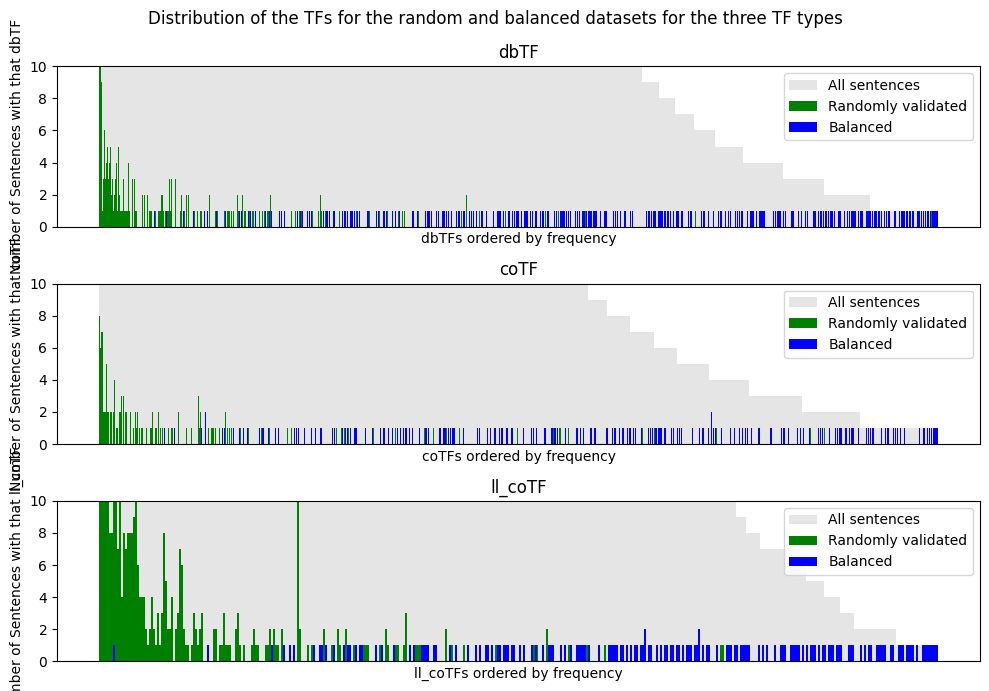

In [150]:
# PLOT
def plot_tf_validation_distribution(ax, tf_type: str, all_sents: pd.DataFrame, val_random: pd.DataFrame, val_balanced: pd.DataFrame, ylim=30):
    for df, label, color, alpha in [
        (all_sents, "All sentences", "grey", 0.2),
        (val_random, "Randomly validated", "green", 1),
        (val_balanced, 'Balanced', "blue", 1)
    ]:
        counts = df['TF Id'].value_counts()
        ax.bar(counts.index, counts, label=label, color=color, alpha=alpha, width=1)
    ax.set_title(tf_type)
    ax.set_xticks([])
    #plt.xticks(rotation='vertical')
    ax.set_ylabel(f"Number of Sentences with that {tf_type}")
    ax.set_xlabel(f"{tf_type}s ordered by frequency")
    ax.set_ylim((0,ylim))
    ax.legend()

def plot_all_tf_validation_distributions(title, ExTRI2_df, validated_1mapping, figsize=(15, 10), ylim=30):

    fig, axes = plt.subplots(3, 1, figsize=figsize)
    for i, TF_type in enumerate(['dbTF', 'coTF', 'll_coTF']):
        TRI_subset = ExTRI2_df[ExTRI2_df['TF_type'] == TF_type]
        validated_subset = validated_1mapping[(validated_1mapping['TF_type_validated'] == TF_type)]

        validated_subset_b = validated_subset[validated_subset['method'] == 'balanced']
        validated_subset_r = validated_subset[validated_subset['method'] == 'random']

        plot_tf_validation_distribution(axes[i], TF_type, TRI_subset, val_balanced = validated_subset_b, val_random = validated_subset_r, ylim=ylim)

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

title = "Distribution of the TFs for the random and balanced datasets for the three TF types"
plot_all_tf_validation_distributions(title, ExTRI2_df, validated_1mapping[(validated_1mapping['pre-post'] == 'pre') & (validated_1mapping['Label'] == 'TRUE')], figsize=(10, 7), ylim = 10)

713 sentences will be removed from the balanced subset
205 sentences will be added to the balanced subset


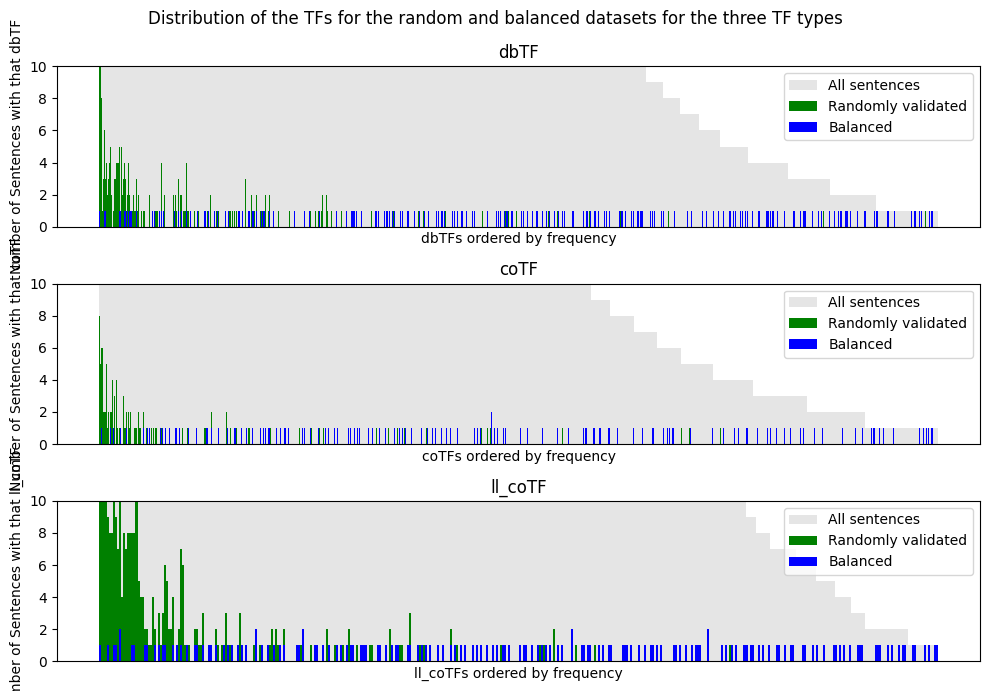

684 sentences will be removed from the balanced subset
221 sentences will be added to the balanced subset


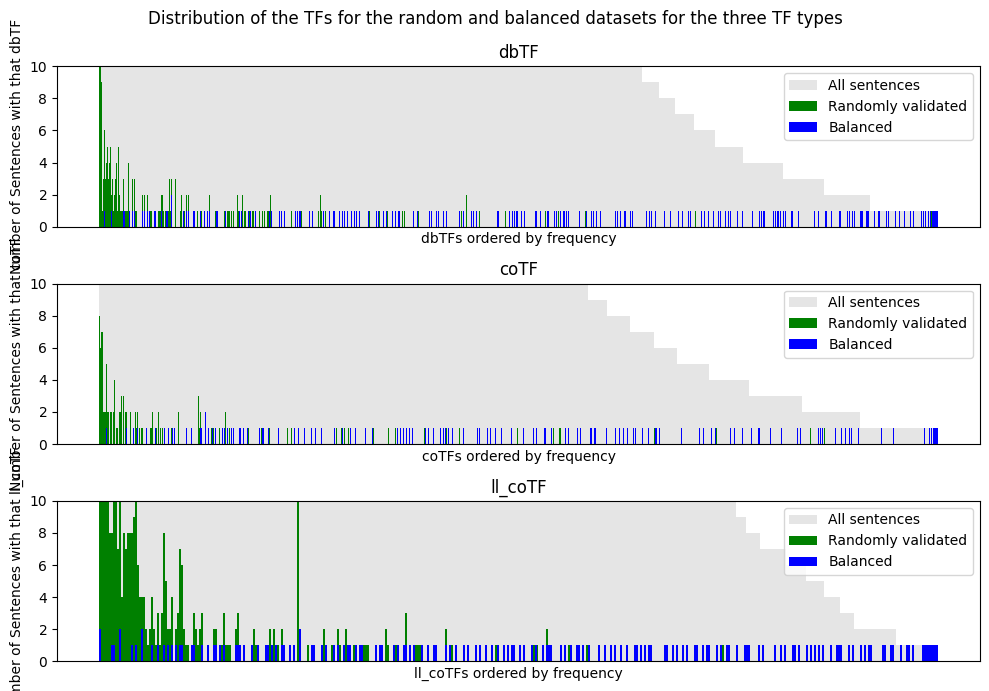

In [151]:
# ADJUST BALANCED DATASET
def adjust_balanced_subset(ExTRI2_df: pd.DataFrame, validated_df_1mapping: pd.DataFrame) -> pd.DataFrame:
    """
    Adjusts the balanced subset of validated_df by adding or removing sentences
    to ensure a consistent number of sentences per batch for each TF type.

    Only takes TFs that have been mapped to 1 only TF Id
    """

    # Sentences to add and to remove from the balanced dataset
    idx_to_add = []
    idx_to_remove = []

    for TF_type in ['dbTF', 'coTF', 'll_coTF']:
        TRI_subset = ExTRI2_df[ExTRI2_df['TF_type'] == TF_type]
        val_subset = validated_df_1mapping[validated_df_1mapping['TF_type'] == TF_type]

        # Get the TF IDs in the ExTRI2 dataset ordered by counts, and those in the validated dataset
        retrieved_TFs = TRI_subset['TF Id'].value_counts().index
        validated_TFs = val_subset['TF Id'].unique()

        # TODO - Explain this line below better
        # The balanced dataset will contain 2 TFs for each batch of 2*(retrieved_TFs / validated_TFs)
        sents_per_batch = 2
        batch = sents_per_batch * 2 * (len(retrieved_TFs) // len(validated_TFs)) + 1
        
        # Separate the random and balanced subsets
        val_subset_b = val_subset[val_subset['method'] == 'balanced']
        val_subset_r = val_subset[val_subset['method'] == 'random']

        # Get a set of random sentences to add to the balanced dataset
        for i in range(0, len(retrieved_TFs), batch):
            # Get the batch of TFs
            TFs_subset = set(retrieved_TFs[i:i+batch])

            # Get corresponding sentences from the balanced subset
            TFs_subset_b = val_subset_b[val_subset_b['TF Id'].isin(TFs_subset)]

            if len(TFs_subset_b) > sents_per_batch:
                # If there are too many sentences, calculate how many to remove
                num_to_remove = len(TFs_subset_b) - sents_per_batch
                # Collect the excess sentences to remove
                idx_to_remove.extend(TFs_subset_b.sample(n=num_to_remove).index.tolist())
            
            elif len(TFs_subset_b) < sents_per_batch:
                # If there are too few sentences, calculate how many to add
                num_to_add = sents_per_batch - len(TFs_subset_b)

                # Remove from TFs subset those that are already in the balanced dataset (if any)
                TFs_subset = TFs_subset.difference(TFs_subset_b['TF Id'])

                # Get sentences from the random subset to add
                TFs_subset_r = val_subset_r[val_subset_r['TF Id'].isin(TFs_subset)]

                # Ensure we don't add the same TF twice
                unique_TFs_subset_r = TFs_subset_r.drop_duplicates(subset='TF Id')

                idx_to_add.extend(TFs_subset_r.sample(n=min(num_to_add, len(unique_TFs_subset_r))).index.tolist())

    # Show how many sentences will be added and removed
    print(f"{len(idx_to_remove)} sentences will be removed from the balanced subset")
    print(f"{len(idx_to_add)} sentences will be added to the balanced subset")

    # Ensure we're adding and removing the expected sentences
    for method, idx in zip(['random', 'balanced'], [idx_to_add, idx_to_remove]):
        assert set(validated_df_1mapping.loc[idx]['method']) == {method}

    # Remove excess sentences from the balanced subset
    validated_df_1mapping = validated_df_1mapping.drop(index=idx_to_remove)

    # Add the selected random sentences to the balanced subset
    sents_to_add = validated_df_1mapping.loc[idx_to_add].copy().reset_index(drop=True)
    sents_to_add['method'] = 'balanced'
    validated_df_1mapping = pd.concat([validated_df_1mapping, sents_to_add]).reset_index(drop=True)

    return validated_df_1mapping

# TODO - Is this correct? Only take into consideration TRUE sentences
validated_1mapping_post = validated_1mapping[(validated_1mapping['pre-post'] == 'post') & (validated_1mapping['Label'] == 'TRUE')]
validated_1mapping_post = adjust_balanced_subset(ExTRI2_df, validated_1mapping_post)
plot_all_tf_validation_distributions(title, ExTRI2_df, validated_1mapping_post, figsize=(10, 7), ylim = 10)

validated_1mapping_pre = validated_1mapping[(validated_1mapping['pre-post'] == 'pre') & (validated_1mapping['Label'] == 'TRUE')]
validated_1mapping_pre = adjust_balanced_subset(ExTRI2_1mapping, validated_1mapping_pre)
plot_all_tf_validation_distributions(title, ExTRI2_df, validated_1mapping_pre, figsize=(10, 7), ylim = 10)


In [152]:
# Display original table
results = validation_results_table(validated_df[validated_df['Label'] == 'TRUE'])
md("Original table")
display(results.set_index(['tf_type', 'method', 'pre-post']).T)

# DISPLAY CORRECTED TABLE
md("Final table (without FALSEs not multiple mappings)")
validated_1mapping = pd.concat([validated_1mapping_pre, validated_1mapping_post], ignore_index=True)
results = validation_results_table(validated_1mapping[validated_1mapping['Label'] == 'TRUE'])
pd.reset_option("display.float_format")
display(results.set_index(['tf_type', 'method', 'pre-post']).T)

results.set_index(['tf_type', 'method', 'pre-post']).T.to_csv('tables/validation_results.tsv', sep='\t')

Original table

tf_type       dbTF                         coTF                      ll_coTF  \
method      random       balanced        random       balanced        random   
pre-post       pre  post      pre   post    pre  post      pre  post     pre   
num_sents      907   888     1199   1192    514   468      707   684     460   
total        84.3% 85.6%    79.2%  83.2%  61.7% 65.6%    60.5% 64.2%   55.7%   
TRI          92.7% 93.8%    82.5%  86.5%  64.0% 68.2%    62.8% 66.4%   57.4%   
MoR          91.6% 91.8%    96.7%  96.7%  97.7% 97.4%    97.7% 97.8%   98.3%   
ACTIVATION   96.5% 96.5%    99.0%  98.9%  99.0% 98.9%    98.9% 98.8%   99.1%   
REPRESSION   96.7% 96.8%    98.0%  98.1%  98.8% 98.7%    99.3% 99.4%   99.1%   
UNDEFINED    98.5% 98.4%    99.7%  99.7%  99.8% 99.8%    99.6% 99.6%  100.0%   
norm         95.8% 96.6%    94.0%  95.3%  98.2% 98.7%    96.2% 97.2%   98.0%   
NER          99.1% 99.2%    99.9% 100.0%  99.8% 99.8%    99.7% 99.7%  100.0%   
MoR_2        91.6% 91.8%    96.7%  96.7%  97.7% 97.4%    97.7% 97.8%   98.3%   
total_2      84.3% 85.6%    79.2%  83.2%  61.7% 65.6%    60.5% 64.2%   55.7%   
total_final  79.3% 81.4%    73.1%  78.5%  59.7% 64.1%    56.4% 61.1%   53.7%   

tf_type                             
method             balanced         
pre-post      post      pre   post  
num_sents      419      291    332  
total        59.7%    46.4%  48.8%  
TRI          61.6%    48.1%  50.9%  
MoR          98.1%    98.3%  97.9%  
ACTIVATION   99.0%    99.3%  99.4%  
REPRESSION   99.0%    99.0%  98.5%  
UNDEFINED   100.0%   100.0% 100.0%  
norm         98.8%    90.7%  91.9%  
NER         100.0%   100.0%  99.7%  
MoR_2        98.1%    98.3%  97.9%  
total_2      59.7%    46.4%  48.8%  
total_final  58.5%    37.1%  40.4%

Final table (without FALSEs not multiple mappings)

tf_type          dbTF                                    coTF            \
method         random            balanced              random             
pre-post          pre      post       pre      post       pre      post   
num_sents         906       887       639       619       508       462   
total        0.843267  0.855693  0.802817  0.840065  0.616142  0.655844   
TRI          0.927152  0.937993  0.834116  0.870759  0.639764  0.681818   
MoR          0.916115    0.9177  0.968701  0.969305  0.976378  0.974026   
ACTIVATION    0.96468  0.965051  0.992175  0.995153  0.990157  0.989177   
REPRESSION   0.966887  0.968433  0.976526  0.978998  0.988189  0.987013   
UNDEFINED    0.984547  0.984216       1.0  0.995153  0.998031  0.997835   
norm         0.958057  0.966178  0.971831   0.96769  0.982283  0.987013   
NER           0.99117  0.992108   0.99687       1.0  0.998031  0.997835   
MoR_2        0.916115    0.9177  0.968701  0.969305  0.976378  0.974026   
total_2      0.843267  0.855693  0.802817  0.840065  0.616142  0.655844   
total_final  0.792494   0.81398  0.771518  0.807754  0.596457  0.640693   

tf_type                           ll_coTF                                
method       balanced              random            balanced            
pre-post          pre      post       pre      post       pre      post  
num_sents         412       396       435       396       166       163  
total        0.601942  0.666667  0.544828  0.588384       0.5  0.515337  
TRI          0.623786  0.689394  0.563218  0.608586  0.524096  0.533742  
MoR          0.978155  0.977273  0.981609  0.979798  0.975904  0.981595  
ACTIVATION   0.985437  0.987374  0.990805  0.989899  0.987952  0.993865  
REPRESSION   0.997573  0.992424  0.990805  0.989899  0.987952   0.98773  
UNDEFINED    0.995146  0.997475       1.0       1.0       1.0       1.0  
norm         0.978155  0.984848  0.986207  0.989899  0.945783  0.969325  
NER          0.995146  0.997475       1.0       1.0       1.0  0.993865  
MoR_2        0.978155  0.977273  0.981609  0.979798  0.975904  0.981595  
total_2      0.601942  0.666667  0.544828  0.588384       0.5  0.515337  
total_final  0.575243   0.64899  0.531034  0.578283  0.445783  0.478528

COMMENT:
* MoR remains largely unaffected by whether it is pre, post, random or not random. It is constant.
* TRI, however, is more affected. Specially for dbTF, we see a drop of 10% in the accuracy of the model when calculating balanced datasets. A trend that is not observable in coTF. This shows that our model has been trained to somewhat learn the most popular TFs
* However, for coTF it doesn't change much, as it hasn't been trained on coTFs, proving even more that it has learned about the dbTFs to consider as positives. The model is therefore better at recalling more popular TFs than those that it hasn't seen on the training set.
* For the balanced, there is a big leap between pre- and post-, which I should try to find a way to understand

In [153]:
# TODO - Investigate why there's such a big increase in the % for the balanced between pre and post

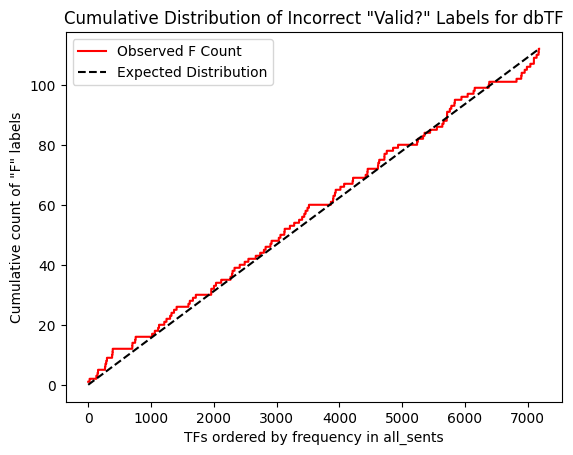

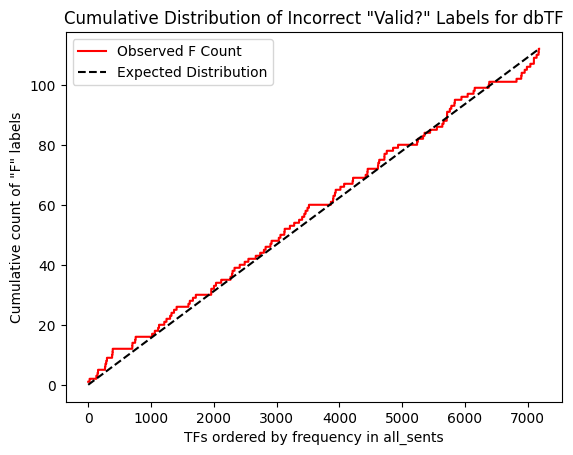

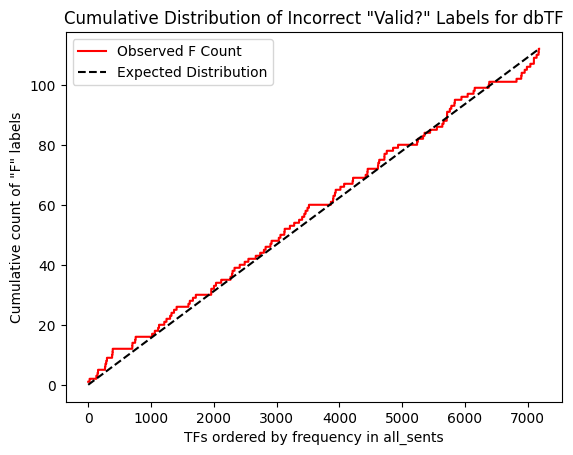

In [154]:
# ChatGPT's plot. let's see
def plot_false_validation_distribution(tf_type: str, all_sents: pd.DataFrame, val_df: pd.DataFrame):

    # Get the subset of balanced TF_type sentences
    val_balanced = val_df[(val_df['TF_type'] == tf_type) & (val_df['method'] == 'balanced')]

    # Step 1: Count TF frequency in all_sents and sort them
    tf_counts = all_sents['TF Id'].value_counts().sort_values(ascending=False)
    
    # Step 2: Filter sentences in val_balanced with 'Valid?' == 'F'
    val_false = val_balanced[val_balanced['Valid?'] == 'F']
    
    # Step 3: Count 'F's for each TF in val_balanced
    val_false_counts = val_false['TF Id'].value_counts().reindex(tf_counts.index, fill_value=0)
    
    # Step 4: Calculate the cumulative sum of 'F's
    cumulative_f_counts = val_false_counts.cumsum()
    
    # Step 5: Plot the cumulative sum of 'F's
    fig, ax = plt.subplots()
    ax.step(range(len(cumulative_f_counts)), cumulative_f_counts, where='mid', label='Observed F Count', color='red')
    
    # Step 6: Plot the expected line
    total_f_count = val_false_counts.sum()
    ax.plot(range(len(cumulative_f_counts)), [total_f_count * (i / len(cumulative_f_counts)) for i in range(len(cumulative_f_counts))], label='Expected Distribution', linestyle='--', color='black')
    
    # Step 7: Customize plot
    ax.set_title(f'Cumulative Distribution of Incorrect "Valid?" Labels for {tf_type}')
    ax.set_xlabel('TFs ordered by frequency in all_sents')
    ax.set_ylabel('Cumulative count of "F" labels')
    ax.legend()
    plt.show()

# TODO - Ensure the map below is correct. Why is it that different from what I saw before? Check more thoroughly
# Example call
for TF_type in ['dbTF', 'coTF', 'll_coTF']:
    plot_false_validation_distribution('dbTF', ExTRI2_df, validated_1mapping_pre)


### MUST CORRECT

In [155]:
# TODO - Validation dataset is not complete. Sort out all the TODOs here & move it to validation.ipynb
print(len(validated_df[validated_df['pre-post'] == 'pre']['Sentence'].unique()))

4078


In [156]:
# DIFFERENT TODOs
# TODO - Astrid considered "Negation" as positive. I should change this in validation. (haven't I already? Check)

# TODO - the "dir-syntax" and "dir-?" are not analysed at all. Should I?
# TODO - If I show Astrid, put it in a more appropriate folder
# TODO - Check if 'Negation' is considered as positive or negative
m = validated_df['Other issues'].str.contains('negation')


# TODO - Talk with Astrid on what to do with those sentences
# TODO - Add also the ones obtained from the iterations on the NTNU dataset. 
#        & save them somewhere
# Number of PPI sentences: 
validated_df['Other issues'].fillna('', inplace=True)
m = validated_df['Other issues'].str.contains('PPI')
validated_df[m]['TF_type_validated'].value_counts()

TF_type_validated
coTF       487
ll_coTF    314
dbTF       150
Name: count, dtype: int64

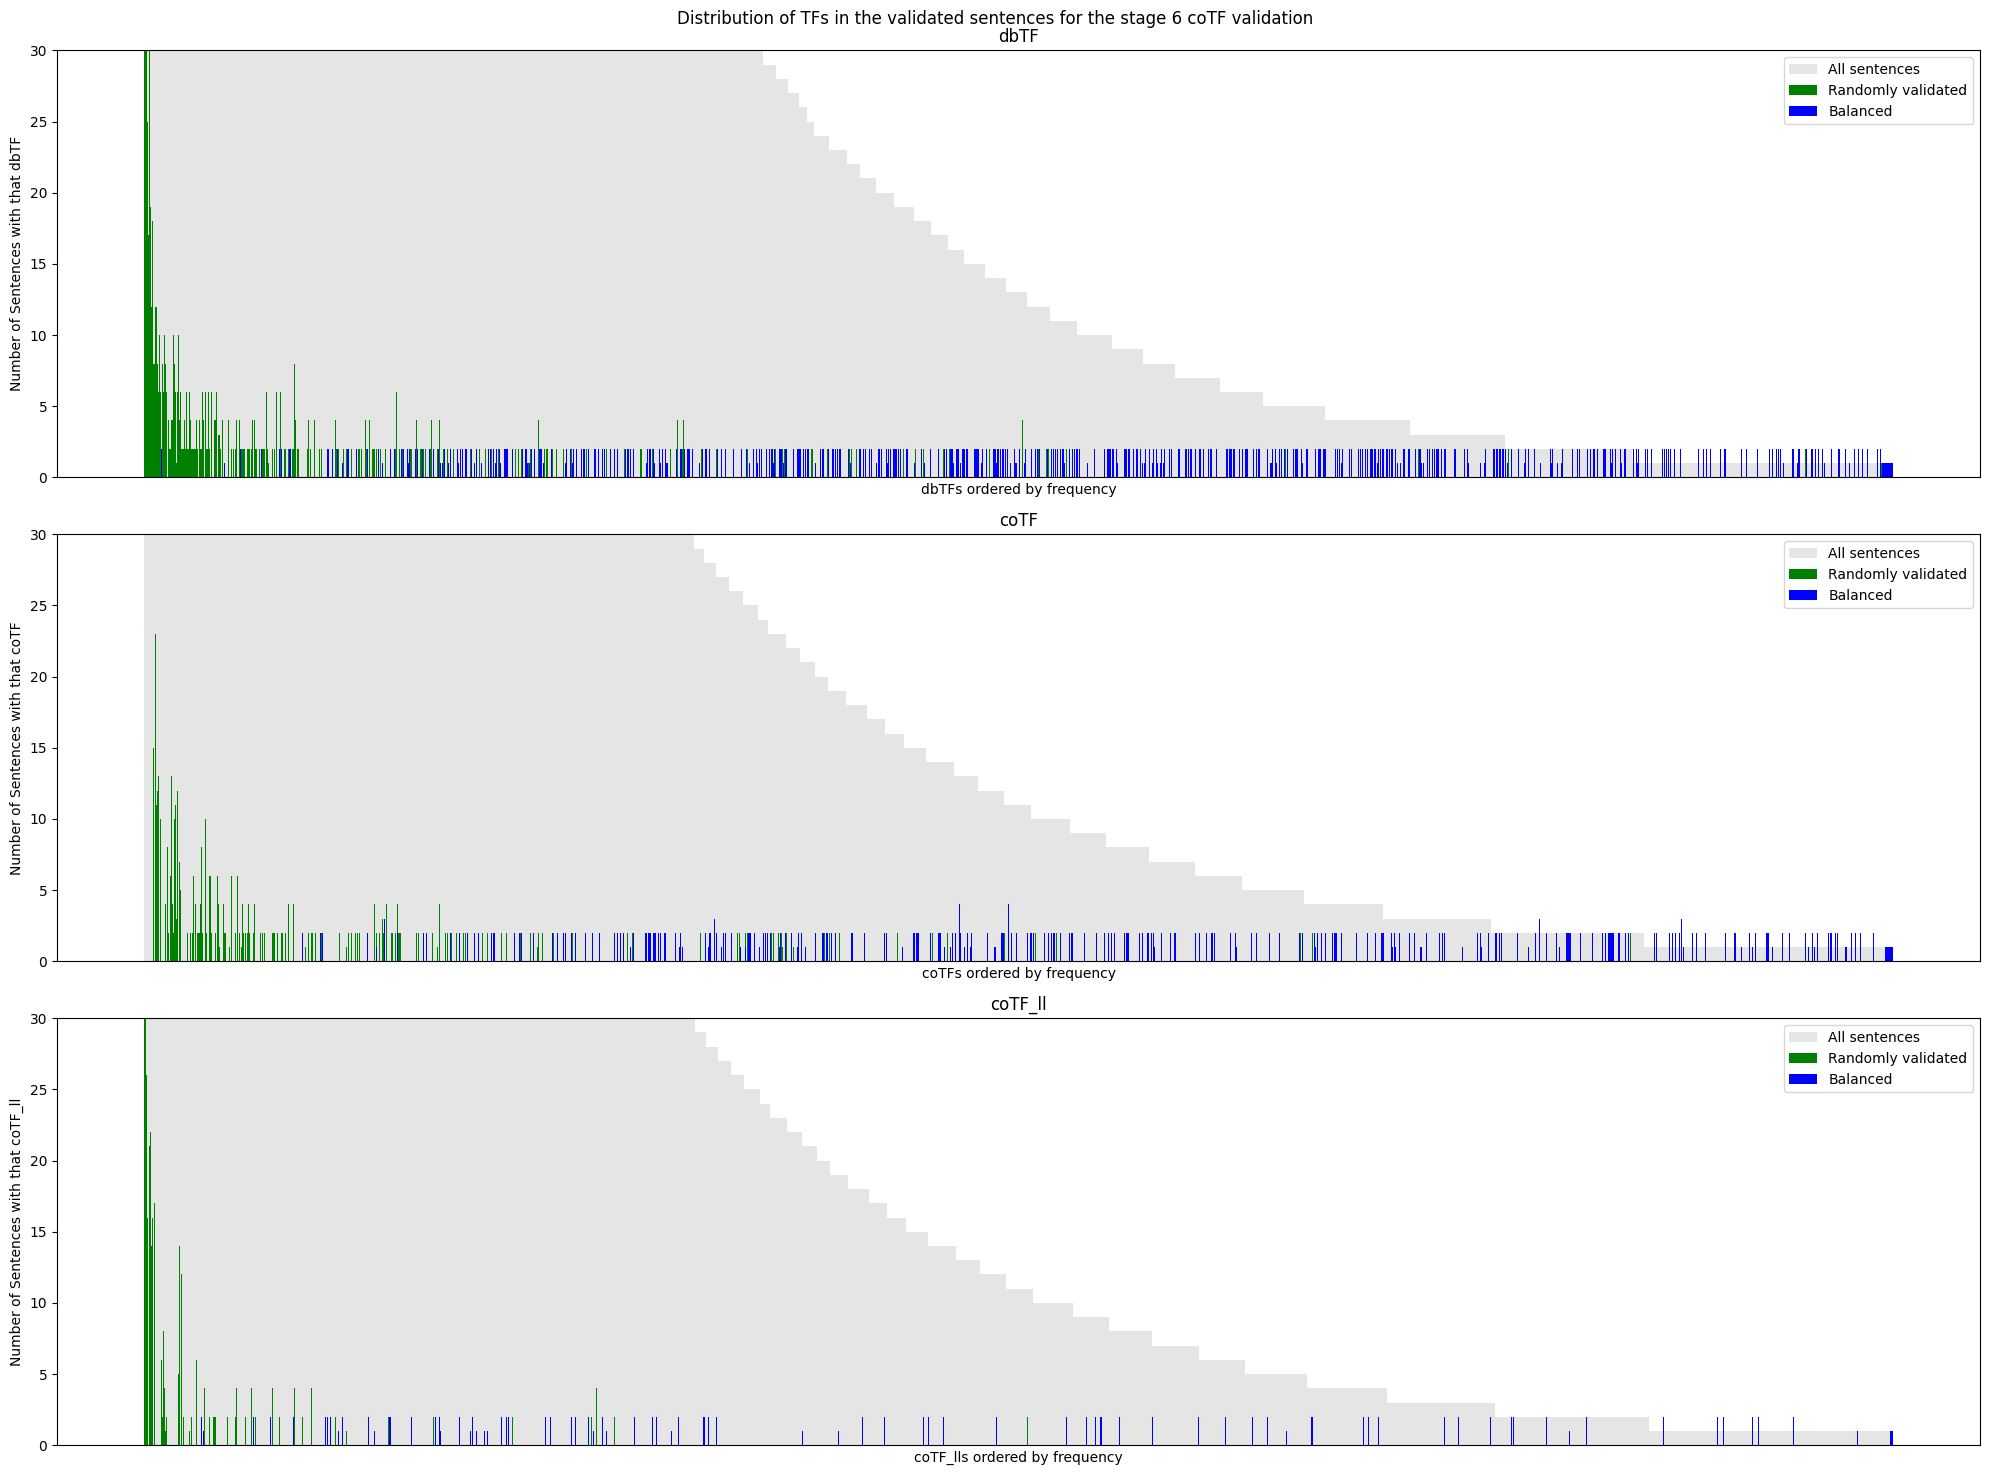

In [157]:
# TODO - Remove this plot maybe? It includes those mapped to +1 TFs
# Get TRI & validated datasets
TRI_dbTF = ExTRI2_df[ExTRI2_df['TF_type'].str.contains('dbTF')]
TRI_coTF = ExTRI2_df[(ExTRI2_df['TF_type'].str.contains('coTF')) & (~ExTRI2_df['TF_type'].str.contains('dbTF'))]


dbTF_val_b = validated_df[(validated_df['TF_type'] == 'dbTF') & (validated_df['method'] == 'balanced')]
dbTF_val_r = validated_df[(validated_df['TF_type'] == 'dbTF') & (validated_df['method'] == 'random')]
coTF_val_b = validated_df[(validated_df['TF_type'] == 'coTF') & (validated_df['method'] == 'balanced')]
coTF_val_r = validated_df[(validated_df['TF_type'] == 'coTF') & (validated_df['method'] == 'random')]
coTF_ll_val_b = validated_df[(validated_df['TF_type'] == 'll_coTF') & (validated_df['method'] == 'balanced')]
coTF_ll_val_r = validated_df[(validated_df['TF_type'] == 'll_coTF') & (validated_df['method'] == 'random')]


# Plot
fig, axes = plt.subplots(3, 1, figsize=(20, 15))
plot_tf_validation_distribution(axes[0], 'dbTF', TRI_dbTF, val_balanced = dbTF_val_b, val_random = dbTF_val_r)
plot_tf_validation_distribution(axes[1], 'coTF', TRI_coTF, val_balanced = coTF_val_b, val_random = coTF_val_r)
# TODO - This is incorrect as it doesn't include the ll_coTF TRI correctly
plot_tf_validation_distribution(axes[2], 'coTF_ll', TRI_coTF, val_balanced = coTF_ll_val_b, val_random = coTF_ll_val_r)

plt.suptitle("Distribution of TFs in the validated sentences for the stage 6 coTF validation")
plt.tight_layout()
plt.show()

In [158]:
# Analytics
def display_dict(analysis_dict: dict, columns=["Correct", "Total"]):
    """
    Input format: dict(list[:2]) where list[0] is a subset of list[1].
    Displays the dict and the percentage between list[0]/list[1]
    TODO - Is this a correct docstring? Improve w/ChatGPT
    """
    df = pd.DataFrame.from_dict(analysis_dict, orient="index", columns=columns)
    df['perc'] = df['Correct'] / df['Total'] * 100
    display(df)

labels = ["dbTF random", "dbTF balanced", "coTF random", "coTF balanced", "coTF ll random", "coTF ll balanced"]
dfs    = [dbTF_val_r, dbTF_val_b, coTF_val_r, coTF_val_b, coTF_ll_val_r, coTF_ll_val_b]

h3("TRI + MoR")
display_dict({label: [(df['Valid?'] == 'T').sum(), len(df)] for label, df in zip(labels, dfs)})

h3("TRI")
display_dict({label: [(~((df['Valid?'] == 'F') & (df['true_label'] != df['Label']))).sum(), 
                      len(df)] for label, df in zip(labels, dfs)})

h3("MoR")
def get_correct_total_MoR(df):
    total = (~((df['Valid?'] == 'F') & (df['true_label'] != df['Label']))).sum()
    incorrect = ((df['Valid?'] == 'F') & (df['true_label'] == df['Label']) & (df['Label'] == "TRUE")).sum()
    return (total - incorrect, total)
display_dict({label: get_correct_total_MoR(df) for label, df in zip(labels, dfs)})

h3("Norm/NER")
display_dict({label: [(df['TF_is_incorrect'].isna() & df['TF_is_incorrect'].isna()).sum(), len(df)] for label, df in zip(labels, dfs)})
# TODO - I don't believe the Norm/NER results. Check if that's biased due to NFKB still marked as unvalid

md("Isues in all sentences")
display(validated_df['Other issues'].value_counts())
print(len(validated_df))

md("Issues in unvalid sentences")
display(validated_df[validated_df['Valid?'] == 'F']['Other issues'].value_counts())
print(len(validated_df[validated_df['Valid?'] == 'F']))

md("Issues in unvalid dbTFsentences")
display(validated_df[(validated_df['Valid?'] == 'F') & (validated_df['TF_type'] == 'dbTF')]['Other issues'].value_counts())
print("Num invalid: ", len(validated_df[(validated_df['Valid?'] == 'F') & (validated_df['TF_type'] == 'dbTF')]))
print("Num dbTF: ", len(validated_df[(validated_df['TF_type'] == 'dbTF')]))


<h3>TRI + MoR</h3>

,Correct,Total,perc
dbTF random,1523,1793,84.941439
dbTF balanced,1499,1835,81.689373
coTF random,616,970,63.505155
coTF balanced,726,1177,61.682243
coTF ll random,470,831,56.558363
coTF ll balanced,171,354,48.305085


<h3>TRI</h3>

,Correct,Total,perc
dbTF random,1672,1793,93.251534
dbTF balanced,1547,1835,84.305177
coTF random,640,970,65.979381
coTF balanced,754,1177,64.061172
coTF ll random,486,831,58.483755
coTF ll balanced,179,354,50.564972


<h3>MoR</h3>

,Correct,Total,perc
dbTF random,1523,1672,91.088517
dbTF balanced,1499,1547,96.897220
coTF random,616,640,96.250000
coTF balanced,726,754,96.286472
coTF ll random,470,486,96.707819
coTF ll balanced,171,179,95.530726


<h3>Norm/NER</h3>

,Correct,Total,perc
dbTF random,1770,1793,98.717234
dbTF balanced,1774,1835,96.675749
coTF random,950,970,97.938144
coTF balanced,1128,1177,95.836873
coTF ll random,814,831,97.954272
coTF ll balanced,339,354,95.762712


Isues in all sentences

Other issues
                          5767
mutation                  1825
PPI                        938
Splitter                    94
negation                    65
mutation;negation           40
suboptimal                  17
TP53;mutation               14
Splitter;mutation           10
PPI;Splitter                 6
ESR1;mutation                4
SMAD4;mutation               3
Smad4;SMAD4;mutation         2
FOXL2;mutation               2
Pparg;PPARG;mutation         2
CEBPA;mutation               2
PAX4;mutation                2
AR;mutation                  2
MAFA;MAFB                    2
STAT1;mutation               2
FOXP3;mutation               2
DNMT3A;mutation              2
STAT3;mutation               2
CBX2                         2
CYP3A4;PPARA;mutation        2
HNF1B;mutation               2
PA2G4;Pa2g4;mutation         2
PPI;suboptimal               2
PPI;negation                 2
HIF1A                        2
TP53                         1
NFAT5                     

8829


Issues in unvalid sentences

Other issues
                          1321
PPI                        938
mutation                   119
Splitter                    42
negation                    24
suboptimal                  16
mutation;negation           12
TP53;mutation                6
PPI;Splitter                 6
ESR1;mutation                4
DNMT3A;mutation              2
STAT1;mutation               2
PPI;suboptimal               2
PPI;negation                 2
HIF1A                        2
NFAT5                        1
PPI;TP53                     1
TP53                         1
Ezh2;JAK2;mutation           1
NONO                         1
IRF9;Irf9;PPI                1
LIN28A;Lin28a;mutation       1
Splitter;mutation            1
PPI;mutation                 1
PDX1                         1
THRB                         1
Name: count, dtype: int64

2509


Issues in unvalid dbTFsentences

Other issues
                     407
PPI                  100
mutation              44
Splitter              22
suboptimal             8
mutation;negation      6
ESR1;mutation          4
TP53;mutation          4
negation               3
STAT1;mutation         2
DNMT3A;mutation        2
PPI;Splitter           2
PDX1                   1
THRB                   1
Name: count, dtype: int64

Num invalid:  606
Num dbTF:  3628


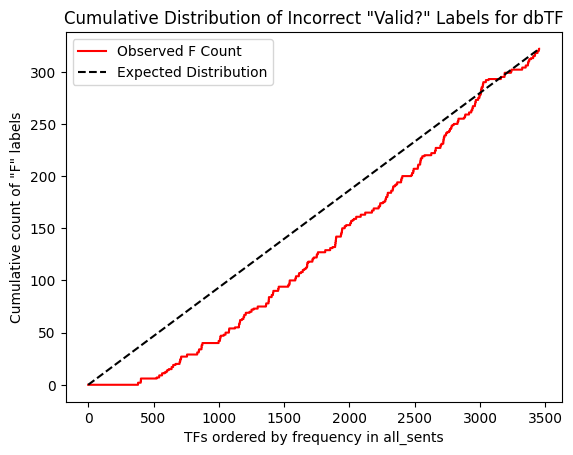

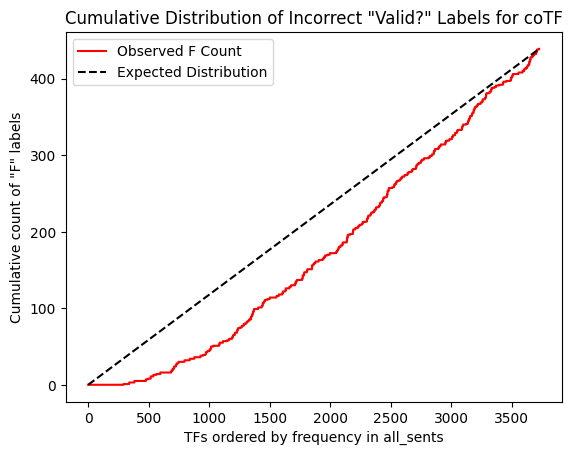

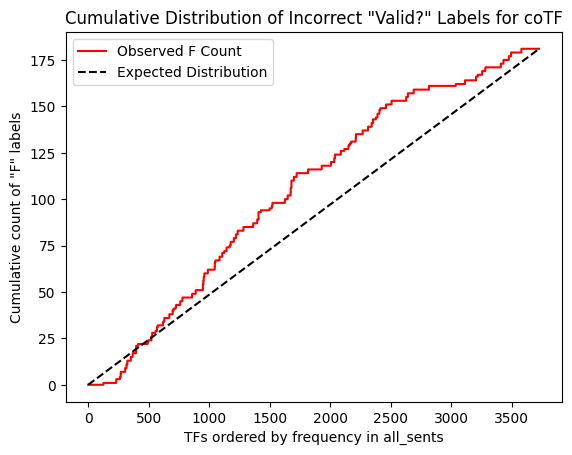

In [159]:
# ChatGPT's plot. let's see
def plot_false_validation_distribution(tf_type: str, all_sents: pd.DataFrame, val_balanced: pd.DataFrame):
    # Step 1: Count TF frequency in all_sents and sort them
    tf_counts = all_sents['TF Id'].value_counts().sort_values(ascending=False)
    
    # Step 2: Filter sentences in val_balanced with 'Valid?' == 'F'
    val_false = val_balanced[val_balanced['Valid?'] == 'F']
    
    # Step 3: Count 'F's for each TF in val_balanced
    val_false_counts = val_false['TF Id'].value_counts().reindex(tf_counts.index, fill_value=0)
    
    # Step 4: Calculate the cumulative sum of 'F's
    cumulative_f_counts = val_false_counts.cumsum()
    
    # Step 5: Plot the cumulative sum of 'F's
    fig, ax = plt.subplots()
    ax.step(range(len(cumulative_f_counts)), cumulative_f_counts, where='mid', label='Observed F Count', color='red')
    
    # Step 6: Plot the expected line
    total_f_count = val_false_counts.sum()
    ax.plot(range(len(cumulative_f_counts)), [total_f_count * (i / len(cumulative_f_counts)) for i in range(len(cumulative_f_counts))], label='Expected Distribution', linestyle='--', color='black')
    
    # Step 7: Customize plot
    ax.set_title(f'Cumulative Distribution of Incorrect "Valid?" Labels for {tf_type}')
    ax.set_xlabel('TFs ordered by frequency in all_sents')
    ax.set_ylabel('Cumulative count of "F" labels')
    ax.legend()
    plt.show()

# Example call
plot_false_validation_distribution('dbTF', TRI_dbTF, dbTF_val_b)
plot_false_validation_distribution('coTF', TRI_coTF, coTF_val_b)
plot_false_validation_distribution('coTF', TRI_coTF, coTF_ll_val_b)
